In [1]:
import whetlab
import pandas as pd
import numpy as np
from scipy import ndimage
from sklearn import cross_validation
from sklearn import decomposition as decomp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
np.set_printoptions(suppress=True, precision=3)
from blurd.util import *
from scipy import stats
from sklearn.metrics import precision_score, recall_score
import seaborn as sns

In [2]:
#####################################
# What experiment are we looking at?
#####################################

filename = "/Users/Alex/Dropbox/Science/Side Projects/Blood Testing/data.pandas"

In [3]:
## Load the data and calculate strata

sdf = pd.read_pickle(filename)

# Create a unique tag for each patient
sdf['patient'] = sdf.sample+"-"+sdf.date

# Select only good vials
sdf = sdf[sdf.good == True]

# Fill in the micro/hypo calls based on these criteria (AND THEN MOVE TO THE EXTRACTION NOTEBOOK)
# ALL THESE INDICES ARE TO CALL THE MICRO/HYPOCHROMIC ANEMIC POPULATION
hypo_idx = sdf['%Hypo'] >= 3.9
anemic_woman_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "F") & (sdf.HGB < 12.0) & hypo_idx
anemic_man_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "M") & (sdf.HGB < 13.0) & hypo_idx
anemic_infant_idx = (sdf['Age'] < 5) & (sdf.HGB < 11.0) & hypo_idx
anemic_child_idx = (sdf['Age'] >= 5) & (sdf['Age'] < 15) & (sdf.HGB < 11.5) & hypo_idx
anemic_population_idx = anemic_woman_idx | anemic_man_idx | anemic_infant_idx | anemic_child_idx
sdf.blood_type.values[np.argwhere(anemic_population_idx)[()]] = 'anemic'
sdf.blood_type.values[np.argwhere(anemic_population_idx == False)[()]] = 'normal'

# Gather the blood-type for prediction
int_y = sdf['blood_type'].values.copy()
int_y[int_y == 'anemic'] = 1
int_y[int_y == 'normal'] = 0
int_y = int_y.astype('int32')
sdf['int_blood_type'] = int_y

# Get the patients
patients = sdf.patient.unique()

# For each patient, get the blood-type
patient_blood_type = []
for patient in patients:
    this_patient = sdf[sdf.patient == patient]
    patient_blood_type.append(sdf[sdf.patient == patient].blood_type.values[0])
patient_blood_type = np.array(patient_blood_type)

In [4]:
# # Get the best result, and all results
# scientist = whetlab.Experiment(name='Classifying IDA (patient-based folds)')
# job = scientist.best()
job = {u'C': 31.751086256664323,
 u'centrifugation_time': 2,
 u'n_dimensions': 23,
 u'nphase': 3,
 u'penalty': u'l2',
 u'reduc_method': 3,
 u'softwindow_mean': 46.21489821548001,
 u'softwindow_variance': 26.09274863908755}

In [5]:
def classify(job, sdf, train_patients, train_patient_idx, validation_patient_idx):
    """
    job is the whetlab params
    sdf is the DataFrame
    train_patients are the patient names that we're training on (includes validation in folds)
    train_idx is what we're training on
    validate_idx is what we're testing on
    """
    # Prepare the blood parameter index
    all_data = np.vstack(sdf.data.values)
    blood_param = sdf['int_blood_type'].values
    blood_param_idx = ((sdf.run_time == 2*int(job['centrifugation_time'])) & (sdf.ida == "IDA%d" % job['nphase'])).values

    # Apply a soft window to the data (better than cropping)
    window = stats.norm.pdf(np.arange(all_data.shape[1]), loc=job['softwindow_mean'], scale=job['softwindow_variance'])
    window /= window.max()
    cropped_data = all_data*window[None,:]

    # NOTE: Doing the unsupervised step on all the training data.
    # Other options include:
    # - all data (it's unsupervised so should be fine)
    # - all training data, irrespective of blood parameters (e.g. include all centrifugation times together)
    unsupervised_train_idx = np.array([p in train_patients for p in sdf.patient])
    all_train_data = cropped_data[unsupervised_train_idx & blood_param_idx].copy()
    reduc_method = ['raw','pca','nmf','kernelpca'][job['reduc_method']]
    if reduc_method == "raw":
        processed_data = ndimage.zoom(cropped_data,(1,job['n_dimensions']/cropped_data.shape[1]))
    elif reduc_method == "nmf":
        preprocessor = decomp.NMF(job['n_dimensions']).fit(all_train_data)
        processed_data = preprocessor.transform(cropped_data)
    elif reduc_method == "pca":
        preprocessor = decomp.PCA(job['n_dimensions']).fit(all_train_data)
        processed_data = preprocessor.transform(cropped_data)
    elif reduc_method == "kernelpca":
        preprocessor = decomp.KernelPCA(job['n_dimensions'],'rbf',gamma=1.0).fit(all_train_data)
        processed_data = preprocessor.transform(cropped_data)

    # Prepare the indices for this fold (only using the training patients)
    train_idx = blood_param_idx & np.array([p in train_patients[train_patient_idx] for p in sdf.patient])
    validation_idx = blood_param_idx & np.array([p in train_patients[validation_patient_idx] for p in sdf.patient])

    # Get the data and labels
    train_data = processed_data[train_idx]
    validation_data = processed_data[validation_idx]
    train_y = blood_param[train_idx]
    validation_y = blood_param[validation_idx]

    assert len(train_data) == len(train_y), "Unequal data and label sizes"
    assert len(validation_data) == len(validation_y), "Unequal data and label sizes"

    # Train a model
    learner = LogisticRegression(penalty=job['penalty'], C=job['C'], fit_intercept=True).fit(train_data,train_y) 
    scores = learner.decision_function(validation_data).ravel()
    pred_y = learner.predict(validation_data)
    return validation_y, pred_y, scores, np.argwhere(train_idx)[()], np.argwhere(validation_idx)[()]

In [6]:
spdf = pd.DataFrame([sdf[sdf.patient==p].iloc[0] for p in patients]).reset_index()
pdf = spdf.copy()
pdf['Age'] = pd.cut(spdf['Age'], [0, 5,15,60], right=True, labels=[5,15,60])
# ================================================
# These discrepancies still need to be resolved
# ================================================

print len(spdf[spdf.Sex == "F"])
print len(spdf[spdf.Sex == "M"])
print len(spdf[(pdf.Age == 5) & (pdf.Sex == "F")]) # JWK has 29
print len(spdf[(pdf.Age == 5) & (pdf.Sex == "M")]) # JWK has 36
print len(spdf[(pdf.Age == 15) & (pdf.Sex == "F")]) # JWK has 18
print len(spdf[(pdf.Age == 15) & (pdf.Sex == "M")]) # JWK has 22
print len(spdf[(pdf.Age == 60) & (pdf.Sex == "F")]) # JWK has 27
print len(spdf[(pdf.Age == 60) & (pdf.Sex == "M")]) # JWK has 20

74
78
34
42
16
19
24
17


### Hypochromia  

the condition of having hypochromic RBCs
```
%hypo ≥ 3.9%
```

### Micro/Hypo Anemia  

micro/hypo anemia—the condition of having hypochromic RBCs and low HGB
```
%hypo ≥ 3.9% and when 
HGB < 12.0 g/dl for females over 15 yrs, 
HGB < 13.0 g/dl for males over 15 yrs, 
HGB < 11.0 g/dl for children under 5 yrs, and 
HGB < 11.5 g/dl for children 5 to 15 yrs, and 
```

### IDA  
IDA as micro/hypo anemia when 
```
Micro/Hypo anemia AND
%micro/%hypo < 1.5
```

### β-thalassemia trait
β-thalassemia when

```
Micro/Hypo anemia AND
%micro/%hypo > 1.5
```

### Performance for calling different anemia subtypes

In [7]:
this_sdf = sdf.copy()
hypochromia_idx = np.argwhere((this_sdf['%Hypo'] >= 3.9).values.astype('int32')).ravel()
microhypoanemia_idx = this_sdf['int_blood_type'].values
ida_idx = np.argwhere((this_sdf['%Micro/%Hypo Ratio'] <= 1.5).values & microhypoanemia_idx).ravel()
betatt_idx = np.argwhere((this_sdf['%Micro/%Hypo Ratio'] > 1.5).values & microhypoanemia_idx).ravel()
microhypoanemia_idx = np.argwhere(microhypoanemia_idx).ravel()
normal_idx = np.setdiff1d(range(len(this_sdf)), np.intersect1d(hypochromia_idx,microhypoanemia_idx))

woman_idx = np.argwhere((sdf['Age'] >= 15) & (sdf['Sex'] == "F")).ravel()
man_idx = np.argwhere((sdf['Age'] >= 15) & (sdf['Sex'] == "M")).ravel()
child_idx = np.argwhere((sdf['Age'] >= 5) & (sdf['Age'] < 15)).ravel()
infant_idx = np.argwhere((sdf['Age'] < 5)).ravel()
all_woman_idx = np.argwhere(sdf['Sex'] == "F").ravel()
all_man_idx = np.argwhere(sdf['Sex'] == "M").ravel()
all_adult_idx = np.argwhere(sdf['Age'] > 15).ravel()

labels = np.empty((len(this_sdf)), dtype='|S30')
labels[:] = ''
# labels[woman_idx] = 'woman'
# labels[man_idx] = 'man'
# labels[child_idx] = 'child'
# labels[infant_idx] = 'infant'

for disease_idx,disease_idx_label in zip((ida_idx,normal_idx,hypochromia_idx),("ida","normal","hypochromia")):
    for pop_idx,pop_idx_label in zip((woman_idx,man_idx,child_idx,infant_idx),("woman", "man","child","infant")):
        labels[np.intersect1d(disease_idx,pop_idx)] = pop_idx_label#+"-"+disease_idx_label

# For each patient, get the blood-type
patient_label = []
for patient in patients:
    this_patient = np.argwhere(sdf.patient == patient).ravel()[0]
    patient_label.append(labels[this_patient])
patient_label = np.array(patient_label)

In [8]:
colors = sns.color_palette(n_colors=3)


Hypochromia
General: 0.99 (0.97,1.00)
Confusion Matrix:
[[68  3]
 [ 5 70]]
Between 5 and 15 AUC: 0.98 (0.94, 1.00)
Younger Than 5 AUC: 0.98 (0.96, 1.00)
All Women AUC: 1.00 (0.99, 1.00)
All Men AUC: 0.98 (0.96, 1.00)
All Over 15 AUC: 1.00 (1.00, 1.00)

Micro/Hypo Anemia
General: 0.93 (0.88,0.96)
Confusion Matrix:
[[78 10]
 [12 46]]
Between 5 and 15 AUC: 0.95 (0.89, 0.99)
Younger Than 5 AUC: 0.91 (0.87, 0.96)
All Women AUC: 0.94 (0.90, 0.98)
All Men AUC: 0.91 (0.86, 0.95)
All Over 15 AUC: 1.00 (0.97, 1.00)

IDA
General: 0.89 (0.84,0.94)
Confusion Matrix:
[[81 12]
 [13 40]]
Between 5 and 15 AUC: 0.93 (0.86, 0.98)
Younger Than 5 AUC: 0.86 (0.79, 0.91)
All Women AUC: 0.93 (0.89, 0.97)
All Men AUC: 0.85 (0.79, 0.90)
All Over 15 AUC: 0.99 (0.97, 1.00)


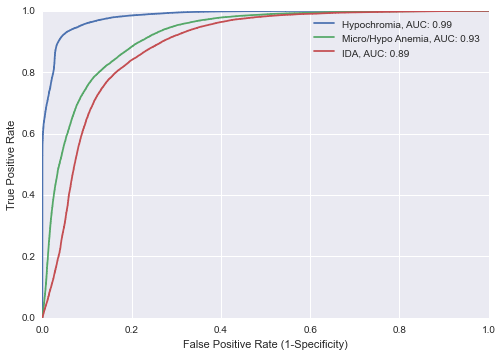

In [42]:
this_sdf = sdf.copy()
figure()
curves = {}
n_folds = 500
for idiagnosis,(this_diagnosis_idx, name) in enumerate(zip([hypochromia_idx, microhypoanemia_idx, ida_idx], 
                                    ["Hypochromia", "Micro/Hypo Anemia", "IDA"])):
    this_sdf = sdf.copy()
    this_labels = np.zeros((len(this_sdf)))
    this_labels[this_diagnosis_idx] = 1
    this_sdf['int_blood_type'] = this_labels
    

    aucs = []
    validation_idxs = []
    true_ys = []
    pred_ys = []
    all_scores = []
    for train, validate in cross_validation.StratifiedShuffleSplit(patient_label, n_iter=n_folds, test_size=0.5):
        true_y, pred_y, scores, train_idx, validation_idx = classify(job, this_sdf, patients, train, validate)
        auc = roc_auc_score(true_y, scores)
        aucs.append(auc)
        validation_idxs.append(validation_idx.ravel())
        true_ys.append(true_y)
        pred_ys.append(pred_y)
        all_scores.append(scores)

    print("\n"+name)
    print("="*50)
    print(u"General: %2.2f (%2.2f,%2.2f)"%tuple(np.percentile(aucs, [50,2.5,97.5])))
    print "Confusion Matrix:"
    confusion_matrices = np.array([confusion_matrix(true_ys[i], pred_ys[i]) for i in range(n_folds)])
    print confusion_matrices.mean(0).astype('int32')
    true_ys = np.array(true_ys)
    pred_ys = np.array(pred_ys)
    all_scores = np.array(all_scores)
    validation_idxs = np.array(validation_idxs)
    
    fpr, tpr, _ = roc_curve(np.hstack(true_ys), np.hstack(all_scores))
    plot(fpr, tpr, label=name+ ", AUC: %2.2f" % np.percentile(np.hstack(aucs),50), color=colors[idiagnosis])
    ylabel("True Positive Rate")
    xlabel("False Positive Rate (1-Specificity)")
    
    curves[name] = {}
    curves[name]['fpr'] = fpr
    curves[name]['tpr'] = tpr
    
    for pop_idx,pop_name in ((child_idx,"Between 5 and 15"),
            (infant_idx,"Younger Than 5"),
            (all_woman_idx,"All Women"),
            (all_man_idx,"All Men"),
            # (woman_idx,"Women Over 15"),
            # (man_idx,"Men Over 15"),
            (all_adult_idx,"All Over 15")):

        pop_auc = []
        for i in range(n_folds):
            this_idx = np.array([v in pop_idx for v in validation_idxs[i]])
            if len(set(true_ys[i][this_idx])) <= 1:
                continue # we only have one class in this fold,disease and population tuple
            pop_auc.append(roc_auc_score(true_ys[i][this_idx], all_scores[i][this_idx]))
        
        if len(pop_auc) > 0:
            print pop_name + " AUC: %2.2f (%2.2f, %2.2f)" % tuple(np.percentile(pop_auc, [50,10,90]))
    
legend()

### Performance across number of phases and centrifugation time

In [64]:
# Do the above cross-validation for nphase=[2,3],centrifugation_time=[2,4,6,8,10]
nphases = [2,3]
centrifugation_times = [1,2,3,4,5] # these get multiplied by two in the classification function
job_copy = dict(job)

outcomes = {}
for nphase in nphases:
    for centrifugation_time in centrifugation_times:
        this_job = dict(job)
        this_job['centrifugation_time'] = centrifugation_time
        this_job['nphase'] = nphase
        aucs = []
        for train, validate in cross_validation.StratifiedShuffleSplit(train_patient_blood_type, n_iter=500, test_size=0.5):
            true_y, pred_y, scores, train_idx, validation_idx = classify(this_job, sdf, train_patients, train, validate)
            auc = roc_auc_score(true_y, scores)
            aucs.append(auc)
        print(u"auc: %2.2f (%2.2f,%2.2f)"%tuple(np.percentile(aucs, [50,5,95])))
        outcomes[nphase,centrifugation_time] = aucs

colors = sns.color_palette(n_colors=2)
for i,nphase in enumerate(nphases):
    for centrifugation_time in centrifugation_times:
        median,lower,upper = np.percentile(outcomes[nphase,centrifugation_time], [50,10,90])
        if centrifugation_time == 1:
            label = "IDA-AMPS-%d"%nphase
        else:
            label = None
        plot(centrifugation_time+i*0.1-0.05, median, 'o', color=colors[nphase-2], label=label)
        vlines(centrifugation_time+i*0.1-0.05, lower, upper, linewidth=1, color=colors[nphase-2])
xlim(0,6)
xticks([1,2,3,4,5], [2,4,6,8,10])
xlabel("Centrifugation Time (min)")
ylabel("AUC")
legend(loc='lower left', fontsize=16)

NameError: name 'train_patient_blood_type' is not defined

In [ ]:
# Print out 5,50,95 CI for 

# phase, run_time, 5, 50, 95 CI
headers = ["nphase", "run_time", "median", "10thpercent", "90thpercent"]
print ",".join(headers)
for nphase in nphases:
    for centrifugation_time in centrifugation_times:
        median,lower,upper = np.percentile(outcomes[nphase,centrifugation_time], [50,10,90])
        print "%s, %d, %2.2f, %2.2f, %2.2f" % (nphase, centrifugation_time*2, lower, median, upper)

### How awful are we with IDA vs bTT?

In [327]:
# Load it up
sdf = pd.read_pickle(filename)

# Create a unique tag for each patient
sdf['patient'] = sdf.sample+"-"+sdf.date

# Select only good vials
sdf = sdf[sdf.good == True]

# Fill in the micro/hypo calls based on these criteria (AND THEN MOVE TO THE EXTRACTION NOTEBOOK)
# ALL THESE INDICES ARE TO CALL THE MICRO/HYPOCHROMIC ANEMIC POPULATION
hypochromia_idx = (sdf['%Hypo'] >= 3.9).values.astype('int32')
anemic_woman_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "F") & (sdf.HGB < 12.0) & hypochromia_idx
anemic_man_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "M") & (sdf.HGB < 13.0) & hypochromia_idx
anemic_infant_idx = (sdf['Age'] < 5) & (sdf.HGB < 11.0) & hypochromia_idx
anemic_child_idx = (sdf['Age'] >= 5) & (sdf['Age'] < 15) & (sdf.HGB < 11.5) & hypochromia_idx
microhypoanemia_idx = (anemic_woman_idx | anemic_man_idx | anemic_infant_idx | anemic_child_idx).values.astype('int32')

ida_idx = (sdf['%Micro/%Hypo Ratio'] <= 1.5).values & microhypoanemia_idx
betatt_idx = (sdf['%Micro/%Hypo Ratio'] > 1.5).values & microhypoanemia_idx

blood_type = sdf['blood_type'].values
orig_blood_type = blood_type.copy()
blood_type[:] = 'normal'
blood_type[np.argwhere(ida_idx)] = 'ida'
blood_type[np.argwhere(betatt_idx)] = 'tt'
# blood_type[hypochromia_idx] = 'hypochromia'
# blood_type[microhypoanemia_idx] = 'microhypo'

sdf['blood_type'] = blood_type

# df = pd.DataFrame([sdf[sdf.patient==patient].iloc[0] for patient in sdf.patient.unique()])
# df['blood_type'].value_counts()

In [399]:
# For just this section! Filter out everything that's not IDA or tt
sdf = sdf[sdf.blood_type!='normal']
sdf['int_blood_type'] = label_binarize(sdf.blood_type.values, ['ida', 'tt']).ravel()

In [400]:
# For each patient, get the blood-type
ida_patient_blood_type = []
patients = sdf.patient.unique()
for patient in patients:
    ida_patient_blood_type.append(sdf[sdf.patient == patient].blood_type.values[0])
ida_patient_blood_type = np.array(ida_patient_blood_type)

In [ ]:
aucs = []
validation_idxs = []
true_ys = []
pred_ys = []
all_scores = []
for train, validate in cross_validation.StratifiedShuffleSplit(train_patient_blood_type, n_iter=50, test_size=0.5):
    true_y, pred_y, scores, train_idx, validation_idx = classify(job, this_sdf, train_patients, train, validate)
    auc = roc_auc_score(true_y, scores)
    aucs.append(auc)
    validation_idxs.extend(validation_idx)
    true_ys.extend(true_y)
    pred_ys.extend(pred_y)
    all_scores.extend(scores)


In [402]:
aucs = []
validation_idxs = []
true_ys = []
pred_ys = []
all_scores = []
for train, validate in cross_validation.StratifiedShuffleSplit(ida_patient_blood_type, n_iter=50, test_size=0.5):
    true_y, pred_y, scores, train_idx, validation_idx = classify(job, sdf, patients, train, validate)
    try:
        auc = roc_auc_score(true_y, scores)
        aucs.append(auc)
        validation_idxs.extend(validation_idx)
        true_ys.extend(true_y)
        pred_ys.extend(pred_y)
        all_scores.extend(scores)
    except:
        continue
    
print(u"auc: %2.2f (%2.2f,%2.2f)"%tuple(np.percentile(aucs, [50,5,95])))
fpr, tpr, _ = roc_curve(true_ys, all_scores)

auc: 0.41 (0.20,0.56)


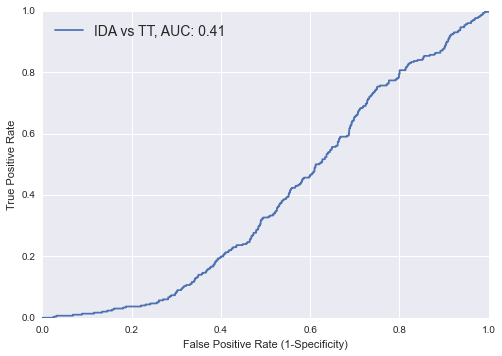

In [409]:
fpr, tpr, _ = roc_curve(true_ys, all_scores)
plot(fpr, tpr, label="IDA vs TT, AUC: %2.2f" % np.percentile(aucs,50))
ylabel("True Positive Rate")
xlabel("False Positive Rate (1-Specificity)")
legend(loc='upper left', fontsize=14)